## Model

In [3]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from PIL import Image

import sys
sys.path.append('../')
from py.mylib import *

In [4]:
target = importTarget("..\data\images\mitosis_img_005.json")

100%|██████████| 976/976 [00:07<00:00, 128.47it/s]


torch.Size([1008, 756])


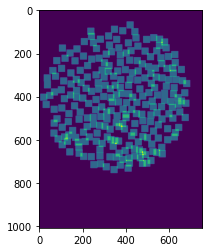

In [5]:
plt.imshow(target)
print(target.shape)

torch.Size([1, 1008, 756])


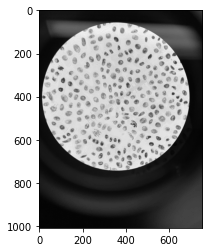

In [6]:
img = importPicture("..\data\images\mitosis_img_005.jpg")
print(img.shape)
plt.imshow(img[0], cmap='gray')
data_loader = torch.utils.data.DataLoader(img, batch_size=5, shuffle=True)